# 03 - Sportstaetten pro Bezirk

**Ziel:** Ermittelt Sportinfrastruktur-Indikatoren pro Stadtbezirk auf OSM-Basis.

**Inputs:** data/interim/muc_bezirke_bev_clean.geojson, OSM-Sportstaetten

**Outputs:** data/processed/muc_bezirke_sport.geojson

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


## Setup

In diesem Abschnitt werden Bibliotheken und Pfade definiert. Damit ist der technische Rahmen für Einlesen, Aufbereitung und Export der Sportdaten reproduzierbar gesetzt.

In [37]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

BASE_DIR = Path("..")
INTERIM_DIR = BASE_DIR / "data" / "interim"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
# Standardisierte Output-Ordner fuer Notebook 03
OUTPUT_DIR = BASE_DIR / "outputs"
FIG_DIR = OUTPUT_DIR / "figures" / "03_sport"
TABLE_DIR = OUTPUT_DIR / "tables" / "03_sport"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)


## Datenbasis


In diesem Abschnitt werden Bezirksgrundlage und OSM-Sportdaten geladen. Ziel ist ein konsistenter räumlicher Ausgangspunkt für die Kennzahlenbildung.

### Bezirk DF laden

In diesem Abschnitt wird der bereinigte Bezirksdatensatz aus Notebook 01 als räumliche Referenz eingebunden. Er ist die Bezugsgeometrie für alle Sportindikatoren.

In [38]:
# Basis: Stadtbezirke laden
gdf_bezirke = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")
gdf_bezirke = gdf_bezirke.sort_values("bez_nr").reset_index(drop=True)
gdf_bezirke.head()


,bez_nr,name,stadtbezirk,einwohner,flaeche_ha,einwohnerdichte,geometry
0,1,Altstadt-Lehel,Altstadt - Lehel,20876,314.59,66.0,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,Ludwigsvorstadt - Isarvorstadt,50081,440.17,114.0,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,Maxvorstadt,52434,429.82,122.0,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,Schwabing West,68610,436.33,157.0,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,Au - Haidhausen,63972,422.00,152.0,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


**Erkenntnisse:**
- Der Bezirksdatensatz ist vollständig und stellt die räumliche Referenz für alle Sportkennzahlen bereit.
- Die Sortierung nach `bez_nr` verbessert die Nachvollziehbarkeit für Tabellen, Karten und spätere Merges.
- Für den Bericht: Die Bezirkskulisse ist damit konsistent zu Notebook 01 und methodisch anschlussfähig.

### Sportstätten aus OpenStreetMap laden

In diesem Abschnitt werden OSM-Sportobjekte abgefragt und in das Bezirks-CRS transformiert. Dadurch sind räumliche Zuordnung und Flächenberechnung methodisch möglich.

In [39]:
place_name = "München, Deutschland"
sport_tags = {"leisure": ["sports_centre", "pitch"]}

gdf_sport = ox.features_from_place(place_name, sport_tags)

# CRS an Bezirkslayer anpassen
gdf_sport = gdf_sport.to_crs(gdf_bezirke.crs)

gdf_sport[["name", "leisure", "geometry"]].head(), len(gdf_sport)


(                  name leisure                        geometry
 element id                                                    
 node    243362188  NaN   pitch  POINT (690314.641 5336477.563)
         243362189  NaN   pitch  POINT (690322.001 5336469.374)
         257546774  NaN   pitch   POINT (696642.61 5332213.561)
         257547095  NaN   pitch  POINT (696720.228 5332172.622)
         266620278  NaN   pitch  POINT (693115.155 5333174.542),
 2570)

**Erkenntnisse:**
- Die OSM-Sportdaten wurden erfolgreich geladen und in das CRS der Bezirke transformiert.
- Damit sind räumliche Zuordnung und Flächenkennzahlen technisch valide berechenbar.
- Für den Bericht: Die Datenquelle ist offen und transparent, zugleich aber OSM-typisch hinsichtlich Erfassungsgrad heterogen.

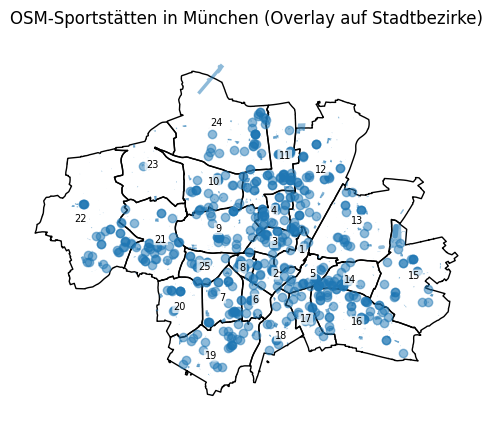

In [40]:
ax = gdf_bezirke.plot(edgecolor="black", facecolor="none", figsize=(6, 6))
gdf_sport.plot(ax=ax, alpha=0.5)
# Bezirksnummern einzeichnen (robust fuer unterschiedliche Spaltennamen)
label_col = "sb_nummer" if "sb_nummer" in gdf_bezirke.columns else "bez_nr"
label_points = gdf_bezirke.geometry.representative_point()
for x, y, sb in zip(label_points.x, label_points.y, gdf_bezirke[label_col]):
    ax.text(
        x,
        y,
        str(sb),
        fontsize=7,
        ha="center",
        va="center",
        color="black",
        bbox=dict(
            facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.12"
        ),
    )
plt.title("OSM-Sportstätten in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.savefig(FIG_DIR / "01_overlay_sport_bezirke.png", dpi=180, bbox_inches="tight")
plt.show()


**Erkenntnisse:**
- Die Overlay-Karte zeigt eine räumlich plausible Verteilung der Sportobjekte über das Stadtgebiet.
- Sichtbar ist bereits eine ungleiche Konzentration zwischen Bezirken, was die spätere Kennzahlenanalyse inhaltlich stützt.
- Für den Bericht: Dieser Schritt dient als visuelle Plausibilitätsprüfung vor der Aggregation.

## Datenaufbereitung

In diesem Abschnitt werden Sportobjekte Bezirken zugeordnet und zu Kennzahlen aggregiert. So entsteht ein vergleichbarer Datensatz je Bezirk.

### Räumliche Zuordnung der Sportstätten zu Stadtbezirken

In diesem Abschnitt werden Sportobjekte räumlich den Bezirken zugeordnet. Damit werden alle weiteren Auswertungen bezirksscharf möglich.

In [41]:
sports = gdf_sport[["name", "leisure", "geometry"]].copy()

sports_in_bezirke = gpd.sjoin(
    sports,
    gdf_bezirke[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects",
)

sports_in_bezirke[["name", "leisure", "bez_nr"]].head(10)


name        leisure  bez_nr
element id                                                            
node    243362188                           NaN          pitch       3
        243362189                           NaN          pitch       3
        257546774                           NaN          pitch      16
        257547095                           NaN          pitch      16
        266620278                           NaN          pitch       5
        291898679               boxt euch durch  sports_centre       1
        292910956                   Boulesplatz          pitch       1
        292969966   Fitness-Studio Arabellapark  sports_centre      13
        295850818                           NaN          pitch      12
        319075477  Skyfit Women München-Giesing  sports_centre      16

**Erkenntnisse:**
- Die räumliche Zuordnung verknüpft Sportobjekte mit Bezirkskennziffern und ermöglicht bezirksscharfe Auswertung.
- Methodisch ist zu beachten: Bei `intersects` können grenznahe Objekte mehreren Bezirken zugeordnet werden.
- Für den Bericht: Diese Annahme sollte als methodischer Hinweis transparent dokumentiert werden.

### Aggregation auf Bezirksebene & Ableitung von Sportstätten-Kennzahlen

In diesem Abschnitt werden absolute und normierte Kennzahlen berechnet. Dadurch werden Bezirke trotz unterschiedlicher Größe und Bevölkerungszahl fair vergleichbar.

In [42]:
# Anzahl Sportstätten pro Bezirk
sports_per_bez = (
    sports_in_bezirke.groupby("bez_nr").size().reset_index(name="sports_count")
)
# Fläche der Sportstätten (wenn Geometrien Flächen sind – sonst kann man Fläche zunächst als optionales Feature sehen)
sports_in_bezirke["sports_area"] = sports_in_bezirke.geometry.area
sports_area_per_bez = (
    sports_in_bezirke.groupby("bez_nr")["sports_area"].sum().reset_index()
)
sports_area_per_bez["sports_area_ha"] = sports_area_per_bez["sports_area"] / 10_000
sports_area_per_bez = sports_area_per_bez[["bez_nr", "sports_area_ha"]]
# Mit Bezirksdaten mergen
gdf_sport_active = gdf_bezirke.merge(sports_per_bez, on="bez_nr", how="left")
gdf_sport_active = gdf_sport_active.merge(sports_area_per_bez, on="bez_nr", how="left")
# Bezirke ohne Sportstätten: NAs auf 0
gdf_sport_active[["sports_count", "sports_area_ha"]] = gdf_sport_active[
    ["sports_count", "sports_area_ha"]
].fillna(0)
# Kennzahlen
gdf_sport_active["sports_pro_1000_einw"] = (
    gdf_sport_active["sports_count"] / gdf_sport_active["einwohner"] * 1000
)
gdf_sport_active["sports_area_ha_pro_1000_einw"] = (
    gdf_sport_active["sports_area_ha"] / gdf_sport_active["einwohner"] * 1000
)
gdf_sport_active["sports_area_anteil_prozent"] = (
    gdf_sport_active["sports_area_ha"] / gdf_sport_active["flaeche_ha"] * 100
)
sport_table = gdf_sport_active[
    [
        "bez_nr",
        "name",
        "sports_count",
        "sports_area_ha",
        "sports_pro_1000_einw",
        "sports_area_anteil_prozent",
    ]
].copy()
sport_table.to_csv(
    TABLE_DIR / "01_sport_kennzahlen_bezirke.csv", index=False, float_format="%.4f"
)
sport_table.head()


,bez_nr,name,sports_count,sports_area_ha,sports_pro_1000_einw,sports_area_anteil_prozent
0,1,Altstadt-Lehel,19,3.843882,0.910136,1.221870
1,2,Ludwigsvorstadt-Isarvorstadt,37,1.203739,0.738803,0.273471
2,3,Maxvorstadt,45,1.081920,0.858222,0.251715
3,4,Schwabing-West,56,6.817058,0.816208,1.562363
4,5,Au-Haidhausen,66,10.829776,1.031701,2.566298


**Erkenntnisse:**
- Die Sportstättenzahl variiert stark zwischen den Bezirken: von **19** (Altstadt-Lehel) bis **257** (Ramersdorf-Perlach), Median **93**.
- `sports_pro_1000_einw` reicht von **0,595** (Laim) bis **2,743** (Milbertshofen-Am Hart), Median **1,439**.
- Für den Bericht: Die Spannweite belegt deutliche Ungleichheiten in der sportbezogenen Infrastrukturversorgung.

## Explorative Analyse der Kennzahlen

In diesem Abschnitt werden die Sportkennzahlen grafisch und tabellarisch interpretiert. Ziel ist eine belastbare Einordnung für den Bericht.

### Räumliche Verteilung: Sportstätten pro 1.000 Einwohner

In diesem Abschnitt wird die räumliche Versorgung mit Sportstätten je Einwohner kartiert. Dadurch werden räumliche Versorgungsschwerpunkte und Lücken sichtbar.

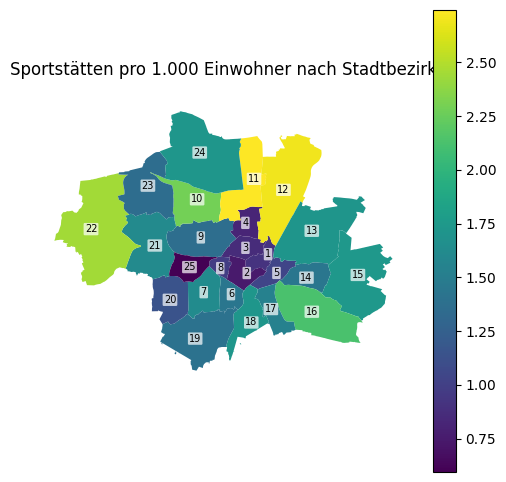

In [43]:
ax = gdf_sport_active.plot(column="sports_pro_1000_einw", legend=True, figsize=(6, 6))
# Bezirksnummern einzeichnen (robust fuer unterschiedliche Spaltennamen)
label_col = "sb_nummer" if "sb_nummer" in gdf_sport_active.columns else "bez_nr"
label_points = gdf_sport_active.geometry.representative_point()
for x, y, sb in zip(label_points.x, label_points.y, gdf_sport_active[label_col]):
    ax.text(
        x,
        y,
        str(sb),
        fontsize=7,
        ha="center",
        va="center",
        color="black",
        bbox=dict(
            facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.12"
        ),
    )
plt.title("Sportstätten pro 1.000 Einwohner nach Stadtbezirk")
plt.axis("off")
plt.savefig(FIG_DIR / "02_choropleth_sport_pro_1000.png", dpi=180, bbox_inches="tight")
plt.show()


**Erkenntnisse:**
- Die Karte zeigt klare räumliche Versorgungsunterschiede bei Sportstätten pro 1.000 Einwohner.
- Hohe Versorgungswerte liegen u. a. in **Milbertshofen-Am Hart (2,743)** und **Schwabing-Freimann (2,698)**.
- Für den Bericht: Die räumliche Perspektive ergänzt die Tabellenanalyse um lokalisierbare Handlungsräume.

### Verteilung: Sportstätten pro 1.000 Einwohner

In diesem Abschnitt wird die Streuung der Pro-Kopf-Sportversorgung statistisch analysiert. So werden typische Wertebereiche sowie Extrembezirke transparent.

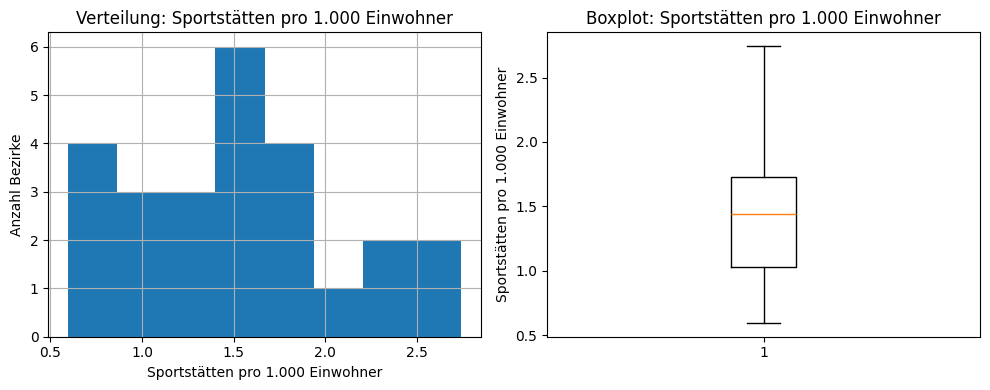

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Histogramm
gdf_sport_active["sports_pro_1000_einw"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Sportstätten pro 1.000 Einwohner")
axes[0].set_xlabel("Sportstätten pro 1.000 Einwohner")
axes[0].set_ylabel("Anzahl Bezirke")
# Boxplot
axes[1].boxplot(gdf_sport_active["sports_pro_1000_einw"], vert=True)
axes[1].set_title("Boxplot: Sportstätten pro 1.000 Einwohner")
axes[1].set_ylabel("Sportstätten pro 1.000 Einwohner")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "03_distribution_sport_pro_1000.png", dpi=180, bbox_inches="tight"
)
plt.show()


**Erkenntnisse:**
- Die Verteilung von `sports_pro_1000_einw` zeigt einen Median von **1,439** (Q1: **1,032**, Q3: **1,725**).
- Oberes Spektrum: **Milbertshofen-Am Hart (2,743)**, **Schwabing-Freimann (2,698)**, **Aubing-Lochhausen-Langwied (2,442)**.
- Unteres Spektrum: **Laim (0,595)**, **Ludwigsvorstadt-Isarvorstadt (0,739)**, **Schwabing-West (0,816)**; dies spricht für relevante Versorgungsunterschiede im Bezirksvergleich.

### Verteilung: Anteil der Sportflächen an der Bezirksfläche

In diesem Abschnitt wird die flächenbezogene Sportinfrastruktur verglichen. Damit wird eine zweite Perspektive neben der Pro-Kopf-Kennzahl ergänzt.

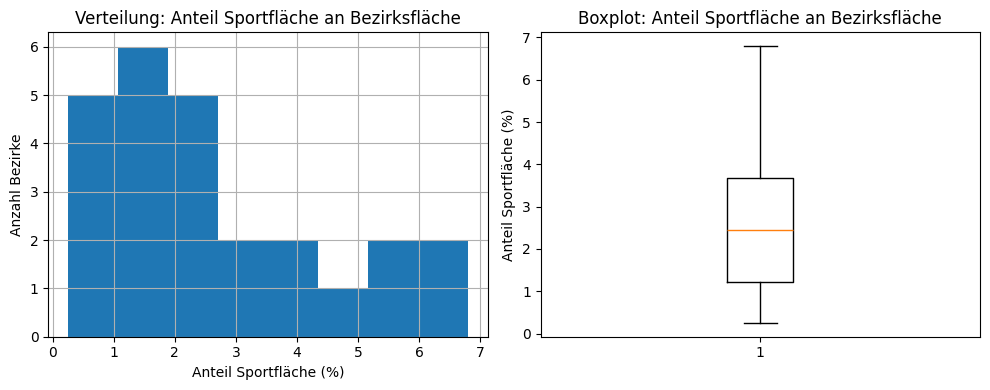

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Histogramm
gdf_sport_active["sports_area_anteil_prozent"].hist(ax=axes[0], bins=8)
axes[0].set_title("Verteilung: Anteil Sportfläche an Bezirksfläche")
axes[0].set_xlabel("Anteil Sportfläche (%)")
axes[0].set_ylabel("Anzahl Bezirke")
# Boxplot
axes[1].boxplot(gdf_sport_active["sports_area_anteil_prozent"], vert=True)
axes[1].set_title("Boxplot: Anteil Sportfläche an Bezirksfläche")
axes[1].set_ylabel("Anteil Sportfläche (%)")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "04_distribution_sport_area_share.png", dpi=180, bbox_inches="tight"
)
plt.show()


**Erkenntnisse:**
- Der Median von `sports_area_anteil_prozent` liegt bei **2,440 %** (Q1: **1,222 %**, Q3: **3,683 %**).
- Hohe Flächenanteile zeigen **Trudering-Riem (6,795 %)**, **Sendling (6,133 %)** und **Milbertshofen-Am Hart (5,975 %)**.
- Niedrige Anteile zeigen **Maxvorstadt (0,252 %)**, **Ludwigsvorstadt-Isarvorstadt (0,273 %)** und **Schwanthalerhöhe (0,711 %)**; für den Bericht ist die Differenz zwischen Flächen- und Pro-Kopf-Perspektive zentral.

### Ranking: Top- und Bottom-Bezirke


In diesem Abschnitt werden Spitzen- und Nachholbezirke direkt gegenübergestellt. Das unterstützt die Priorisierung für die Folgediskussion im Bericht.

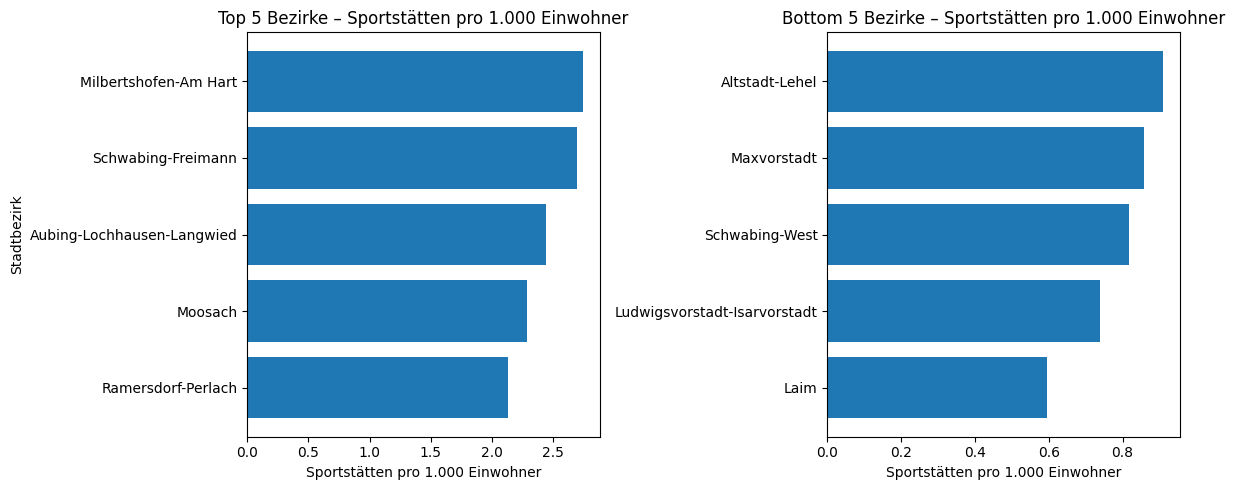

In [46]:
# Top 5
top5_sport = (
    gdf_sport_active[["name", "sports_pro_1000_einw"]]
    .sort_values("sports_pro_1000_einw", ascending=False)
    .head(5)
    .sort_values("sports_pro_1000_einw", ascending=True)
)
# Bottom 5
bottom5_sport = (
    gdf_sport_active[["name", "sports_pro_1000_einw"]]
    .sort_values("sports_pro_1000_einw", ascending=True)
    .head(5)
    .sort_values("sports_pro_1000_einw", ascending=True)
)
top5_sport.to_csv(
    TABLE_DIR / "02_top5_sport_pro_1000.csv", index=False, float_format="%.4f"
)
bottom5_sport.to_csv(
    TABLE_DIR / "03_bottom5_sport_pro_1000.csv", index=False, float_format="%.4f"
)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Top 5
axes[0].barh(top5_sport["name"], top5_sport["sports_pro_1000_einw"])
axes[0].set_title("Top 5 Bezirke – Sportstätten pro 1.000 Einwohner")
axes[0].set_xlabel("Sportstätten pro 1.000 Einwohner")
axes[0].set_ylabel("Stadtbezirk")
# Bottom 5
axes[1].barh(bottom5_sport["name"], bottom5_sport["sports_pro_1000_einw"])
axes[1].set_title("Bottom 5 Bezirke – Sportstätten pro 1.000 Einwohner")
axes[1].set_xlabel("Sportstätten pro 1.000 Einwohner")
axes[1].set_ylabel("")
plt.tight_layout()
plt.savefig(
    FIG_DIR / "05_ranking_top_bottom_sport_pro_1000.png", dpi=180, bbox_inches="tight"
)
plt.show()


**Erkenntnisse:**
- Top-Bezirke bei `sports_pro_1000_einw`: **Milbertshofen-Am Hart (2,743)**, **Schwabing-Freimann (2,698)**, **Aubing-Lochhausen-Langwied (2,442)**.
- Bottom-Bereiche: **Laim (0,595)**, **Ludwigsvorstadt-Isarvorstadt (0,739)**, **Schwabing-West (0,816)**.
- Für den Bericht: Das Ranking liefert eine direkte Grundlage zur Benennung von Prioritäts- und Vergleichsbezirken.

**Zwischenfazit:**
- Die sportbezogenen Kennzahlen zeigen deutliche Unterschiede zwischen den Bezirken in Menge, Pro-Kopf-Versorgung und Flächenanteil.
- Für die Gesamtanalyse ist besonders relevant, dass absolute und normierte Perspektiven nicht dieselben Bezirke hervorheben.
- Diese Ergebnisse bilden die sportbezogene Säule für den späteren Active-City-Gesamtindex.

## Export

In diesem Abschnitt wird der aufbereitete Sportdatensatz für die nächsten Pipeline-Schritte gespeichert. Damit bleibt der Workflow reproduzierbar.

In [47]:
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out_path = PROCESSED_DIR / "muc_bezirke_sport.geojson"
gdf_sport_active.to_file(out_path, driver="GeoJSON")
# Vollständige Sport-Kennzahlen als Tabelle exportieren
gdf_sport_active.drop(columns="geometry").to_csv(
    TABLE_DIR / "04_muc_bezirke_sport_full.csv", index=False, float_format="%.4f"
)
out_path


PosixPath('../data/processed/muc_bezirke_sport.geojson')

**Erkenntnisse:**
- Der Sportdatensatz wurde erfolgreich exportiert und ist für die nächste Pipeline-Stufe verfügbar.
- Das einheitliche GeoJSON-Format erleichtert die spätere Zusammenführung mit Park- und Mobilitätskennzahlen.
- Für den Bericht: Der Export markiert den reproduzierbaren Übergang von Datenerhebung zu integrierter Indexanalyse.